# Load dataset and understand features

In [1]:
# imports for the project 

import time
import pickle
#import faiss
import pandas as pd
import numpy as np
import torch
import torchvision.utils
import torch.nn as nn
import torch.optim as torch_optim
from torch.utils.data import DataLoader, Dataset
import sys
sys.path.insert(1, '/kaggle/input/setup-file/')
from pytorchtools import EStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = '/kaggle/input/setup-file/'
full_data = pd.read_csv(path+"wustl_iiot_2021.csv")
print("wustl_iiot_2021 dataset loaded sucessfully")


wustl_iiot_2021 dataset loaded sucessfully


# Exploratory Data Analysis (EDA)

In [3]:
# Show first 5 rows
full_data.head()

,StartTime,LastTime,SrcAddr,DstAddr,Mean,Sport,Dport,SrcPkts,DstPkts,TotPkts,...,SAppBytes,DAppBytes,TotAppByte,SynAck,RunTime,sTos,SrcJitAct,DstJitAct,Traffic,Target
0,2019-08-19 12:23:28,2019-08-19 12:23:28,192.168.0.20,192.168.0.2,0,59034,502,10,8,18,...,24,20,44,0.001176,0.053037,0,0.000000,0.0,normal,0
1,2019-08-19 15:13:24,2019-08-19 15:13:24,192.168.0.20,192.168.0.2,0,55841,502,10,8,18,...,24,20,44,0.001308,0.052681,0,0.000000,0.0,normal,0
2,2019-08-19 13:41:31,2019-08-19 13:41:31,192.168.0.20,192.168.0.2,0,63774,502,10,8,18,...,24,20,44,0.000690,0.051793,0,0.000000,0.0,normal,0
3,2019-08-19 12:43:19,2019-08-19 12:43:20,209.240.235.92,192.168.0.2,0,61771,80,4,0,4,...,0,0,0,0.000000,0.889555,0,419.338813,0.0,DoS,1
4,2019-08-19 14:49:44,2019-08-19 14:49:48,192.168.0.20,192.168.0.1,3,0,0,14,0,14,...,476,0,476,0.000000,3.500055,0,525.146562,0.0,normal,0


In [4]:
full_data.nunique().sort_values()

Target              2
dTtl                3
Traffic             5
sDSb                5
sTos                5
Mean                6
Proto               8
SrcAddr            14
SrcLoss            68
DstAddr           132
DstLoss           135
Loss              152
IdleTime          200
sTtl              255
pLoss             274
DAppBytes         277
DstPkts           321
DstBytes          446
SAppBytes         468
SrcPkts           567
TotPkts           637
TotAppByte        933
SrcBytes         1592
TotBytes         1742
SynAck           4021
DstJitAct        4293
TcpRtt           4752
Dport            7781
StartTime       25267
LastTime        25276
sIpId           44717
DstRate         46482
Sport           51057
DIntPkt         53631
SrcJitAct       57226
dIpId           65536
DstLoad         65827
Max             81522
RunTime         81522
Min             81522
Sum             81522
Dur             81931
SrcRate         82185
SrcLoad         84158
Rate            89076
SIntPkt   

In [5]:
# Show unique class names and counts
print("Unique classes:", full_data['Traffic'].unique())
print("Number of unique classes:", full_data['Traffic'].nunique())
print("Class distribution:\n", full_data['Traffic'].value_counts())

Unique classes: ['normal' 'DoS' 'Reconn' 'Backdoor' 'CommInj']
Number of unique classes: 5
Class distribution:
 Traffic
normal      1107448
DoS           78305
Reconn         8240
CommInj         259
Backdoor        212
Name: count, dtype: int64


In [6]:
# Class distribution
class_counts = full_data['Traffic'].value_counts()
print(class_counts)

Traffic
normal      1107448
DoS           78305
Reconn         8240
CommInj         259
Backdoor        212
Name: count, dtype: int64


In [7]:
# Percentage distribution
class_percent = full_data['Traffic'].value_counts(normalize=True) * 100
print(class_percent)

Traffic
normal      92.715059
DoS          6.555660
Reconn       0.689849
CommInj      0.021683
Backdoor     0.017749
Name: proportion, dtype: float64


In [8]:
# Data types
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194464 entries, 0 to 1194463
Data columns (total 49 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   StartTime   1194464 non-null  object 
 1   LastTime    1194464 non-null  object 
 2   SrcAddr     1194464 non-null  object 
 3   DstAddr     1194464 non-null  object 
 4   Mean        1194464 non-null  int64  
 5   Sport       1194464 non-null  int64  
 6   Dport       1194464 non-null  int64  
 7   SrcPkts     1194464 non-null  int64  
 8   DstPkts     1194464 non-null  int64  
 9   TotPkts     1194464 non-null  int64  
 10  DstBytes    1194464 non-null  int64  
 11  SrcBytes    1194464 non-null  int64  
 12  TotBytes    1194464 non-null  int64  
 13  SrcLoad     1194464 non-null  float64
 14  DstLoad     1194464 non-null  float64
 15  Load        1194464 non-null  float64
 16  SrcRate     1194464 non-null  float64
 17  DstRate     1194464 non-null  float64
 18  Rate        1194464 no

In [9]:
print("Shape of dataset:", full_data.shape)
#print("\nData types:\n", full_data.dtypes)
print(full_data.columns)

Shape of dataset: (1194464, 49)
Index(['StartTime', 'LastTime', 'SrcAddr', 'DstAddr', 'Mean', 'Sport', 'Dport',
       'SrcPkts', 'DstPkts', 'TotPkts', 'DstBytes', 'SrcBytes', 'TotBytes',
       'SrcLoad', 'DstLoad', 'Load', 'SrcRate', 'DstRate', 'Rate', 'SrcLoss',
       'DstLoss', 'Loss', 'pLoss', 'SrcJitter', 'DstJitter', 'SIntPkt',
       'DIntPkt', 'Proto', 'Dur', 'TcpRtt', 'IdleTime', 'Sum', 'Min', 'Max',
       'sDSb', 'sTtl', 'dTtl', 'sIpId', 'dIpId', 'SAppBytes', 'DAppBytes',
       'TotAppByte', 'SynAck', 'RunTime', 'sTos', 'SrcJitAct', 'DstJitAct',
       'Traffic', 'Target'],
      dtype='object')


In [10]:
# data.describe() only summarizes numeric columns by default.
full_data.describe()

,Mean,Sport,Dport,SrcPkts,DstPkts,TotPkts,DstBytes,SrcBytes,TotBytes,SrcLoad,...,dIpId,SAppBytes,DAppBytes,TotAppByte,SynAck,RunTime,sTos,SrcJitAct,DstJitAct,Target
count,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,...,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06
mean,1.286870e-01,5.445253e+04,7.907604e+02,1.665579e+02,1.688389e+01,1.756631e+02,7.601579e+03,1.938043e+04,2.779692e+05,1.571207e+07,...,2.956785e+04,2.192527e+02,7.051507e+03,6.581117e+05,1.801930e-03,1.994698e-01,7.531412e-03,6.189383e+01,2.653724e-01,7.284941e-02
std,6.859156e-01,1.200834e+04,3.299492e+03,5.266192e+04,1.137763e+03,5.266221e+04,7.508699e+05,4.730229e+06,1.918939e+07,8.339078e+07,...,2.027684e+04,2.852114e+03,7.445876e+05,4.167380e+07,5.485539e-02,7.966451e-01,7.442284e-01,4.143742e+02,5.001929e+00,2.598893e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,5.221800e+04,5.020000e+02,1.000000e+01,8.000000e+00,1.800000e+01,5.080000e+02,6.440000e+02,1.152000e+03,8.514543e+04,...,1.117100e+04,2.400000e+01,2.000000e+01,4.400000e+01,6.310000e-04,5.134900e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.663500e+04,5.020000e+02,1.000000e+01,8.000000e+00,1.800000e+01,5.080000e+02,6.440000e+02,1.152000e+03,8.818777e+04,...,2.934000e+04,2.400000e+01,2.000000e+01,4.400000e+01,6.750000e-04,5.206700e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,6.104300e+04,5.020000e+02,1.000000e+01,8.000000e+00,1.800000e+01,5.080000e+02,6.440000e+02,1.152000e+03,8.968784e+04,...,4.686000e+04,2.400000e+01,2.000000e+01,4.400000e+01,8.020000e-04,5.324900e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.000000e+00,2.765721e+06,6.552200e+04,2.773967e+07,3.092160e+05,2.773967e+07,8.251559e+07,2.108646e+09,2.143725e+09,1.156000e+09,...,6.553500e+04,9.979300e+04,8.182314e+07,4.293700e+09,3.036730e+00,5.103213e+00,2.070000e+02,4.999440e+03,7.695150e+02,1.000000e+00


In [11]:
full_data.describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,StartTime,LastTime,SrcAddr,DstAddr,Mean,Sport,Dport,SrcPkts,DstPkts,TotPkts,...,SAppBytes,DAppBytes,TotAppByte,SynAck,RunTime,sTos,SrcJitAct,DstJitAct,Traffic,Target
count,1194464,1194464,1194464,1194464,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,...,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1194464,1.194464e+06
unique,25267,25276,14,132,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
top,2019-08-19 12:32:29,2019-08-19 12:29:43,192.168.0.20,192.168.0.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,NaN
freq,312,351,1090574,1155810,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1107448,NaN
mean,NaN,NaN,NaN,NaN,1.286870e-01,5.445253e+04,7.907604e+02,1.665579e+02,1.688389e+01,1.756631e+02,...,2.192527e+02,7.051507e+03,6.581117e+05,1.801930e-03,1.994698e-01,7.531412e-03,6.189383e+01,2.653724e-01,NaN,7.284941e-02
std,NaN,NaN,NaN,NaN,6.859156e-01,1.200834e+04,3.299492e+03,5.266192e+04,1.137763e+03,5.266221e+04,...,2.852114e+03,7.445876e+05,4.167380e+07,5.485539e-02,7.966451e-01,7.442284e-01,4.143742e+02,5.001929e+00,NaN,2.598893e-01
min,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,0.000000e+00,5.221800e+04,5.020000e+02,1.000000e+01,8.000000e+00,1.800000e+01,...,2.400000e+01,2.000000e+01,4.400000e+01,6.310000e-04,5.134900e-02,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,NaN,NaN,NaN,NaN,0.000000e+00,5.663500e+04,5.020000e+02,1.000000e+01,8.000000e+00,1.800000e+01,...,2.400000e+01,2.000000e+01,4.400000e+01,6.750000e-04,5.206700e-02,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
75%,NaN,NaN,NaN,NaN,0.000000e+00,6.104300e+04,5.020000e+02,1.000000e+01,8.000000e+00,1.800000e+01,...,2.400000e+01,2.000000e+01,4.400000e+01,8.020000e-04,5.324900e-02,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00


In [12]:
full_data.select_dtypes(exclude='number').columns


Index(['StartTime', 'LastTime', 'SrcAddr', 'DstAddr', 'Traffic'], dtype='object')

In [13]:
full_data.select_dtypes(include='object').columns

Index(['StartTime', 'LastTime', 'SrcAddr', 'DstAddr', 'Traffic'], dtype='object')

In [14]:
# Unique classes
print("Unique classes in Traffic:", full_data['Traffic'].unique())
print("Number of unique classes:", full_data['Traffic'].nunique())

Unique classes in Traffic: ['normal' 'DoS' 'Reconn' 'Backdoor' 'CommInj']
Number of unique classes: 5


In [15]:

# # Percentage of missing per column
# missing_percent = (full_data.isnull().sum() / len(full_data)) * 100
# missing_summary = pd.DataFrame({
#     'missing_count': missing_counts,
#     'missing_percent': missing_percent.sort_values(ascending=False)
# })
# missing_summary.head(20)

In [16]:
# Total missing values per column
missing_counts = full_data.isnull().sum().sort_values(ascending=False)
print(missing_counts)

StartTime     0
SIntPkt       0
Proto         0
Dur           0
TcpRtt        0
IdleTime      0
Sum           0
Min           0
Max           0
sDSb          0
sTtl          0
dTtl          0
sIpId         0
dIpId         0
SAppBytes     0
DAppBytes     0
TotAppByte    0
SynAck        0
RunTime       0
sTos          0
SrcJitAct     0
DstJitAct     0
Traffic       0
DIntPkt       0
DstJitter     0
LastTime      0
SrcJitter     0
SrcAddr       0
DstAddr       0
Mean          0
Sport         0
Dport         0
SrcPkts       0
DstPkts       0
TotPkts       0
DstBytes      0
SrcBytes      0
TotBytes      0
SrcLoad       0
DstLoad       0
Load          0
SrcRate       0
DstRate       0
Rate          0
SrcLoss       0
DstLoss       0
Loss          0
pLoss         0
Target        0
dtype: int64


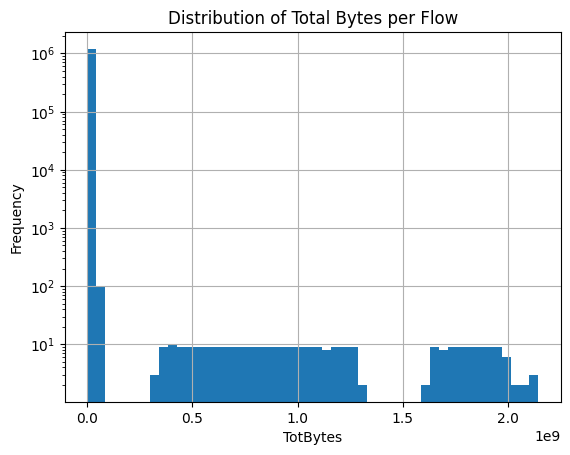

In [17]:
# Histogram for TotBytes
full_data['TotBytes'].hist(bins=50)
plt.title("Distribution of Total Bytes per Flow")
plt.xlabel("TotBytes")
plt.ylabel("Frequency")
plt.yscale('log')  # log scale helps if heavily skewed
plt.show()

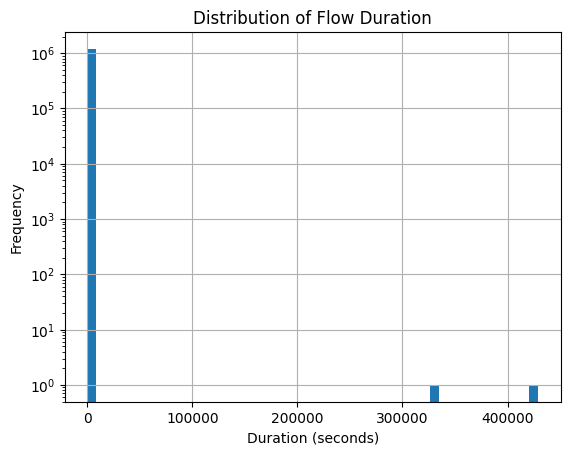

In [18]:
# Histogram for Dur (Duration)
full_data['Dur'].hist(bins=50)
plt.title("Distribution of Flow Duration")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

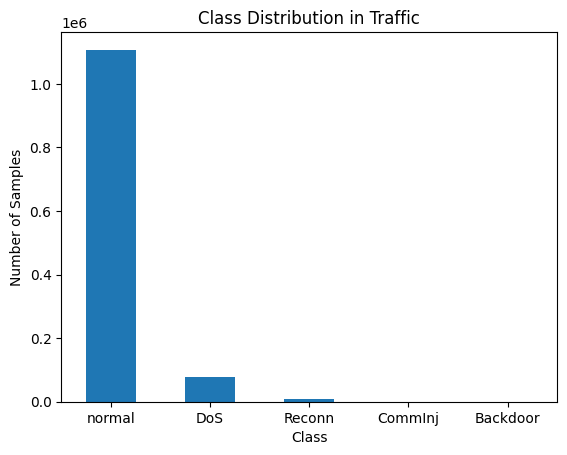

In [19]:
class_counts.plot(kind='bar')
plt.title("Class Distribution in Traffic")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.show()

In [ ]:
full_data[num_cols].describe().T

In [ ]:
!pip install -r /kaggle/input/setup-file/updated-requirements.txt
#!pip install scipy==1.11.3
!pip install pytorch-widedeep
!pip install pytorch-metric-learning
!pip install faiss-cpu
#!pip install faiss-gpu